In [1]:
# !pip install torch
# !pip install pandas
# !pip install numpy
# !pip install transformers
# !pip install openpyxl
# !pip install seaborn
# !pip install matplotlib
# !pip install scikit-learn

In [2]:
import os, warnings, torch
import numpy as np
import pandas as pd
import transformers
import matplotlib.pyplot as plt
from transformers import Trainer, TrainingArguments
warnings.filterwarnings('ignore')

data_dir = os.path.join(os.getcwd(), "Dataset")
output_dir = os.path.join(os.getcwd(), "models", "distilbert-base-uncased")

## Read in dataset

In [3]:
processed_df = pd.read_csv(os.path.join(data_dir,"emotions_processed_df.csv"))
processed_df.sample(5)

,sentiment,content
33981,sadness,joooo rest week less twenty-five hours long
48118,sadness,feel bad
25620,happiness,absolutspacegrl could feel excitement tweet wa...
45105,sadness,feel disappoint spend time something different...
18678,neutral,erinmusicluver think like name


In [4]:
processed_df = processed_df.rename(columns={"sentiment": "labels", "content": "text"})
processed_df.sample(5)

,labels,text
25057,neutral,kaylaphlegar people get fender benders way sch...
51441,sadness,go feel foolish many time
6394,empty,go nap n chill probably go movie later ugh hea...
24812,relief,bofu2u good mornin ya
50117,anger,want exhibit new piece kind make things bite s...


In [5]:
processed_df["labels"].unique()

array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'love',
       'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger', 'fear',
       'happy'], dtype=object)

In [5]:
processed_df.isnull().sum()

labels     0
text      15
dtype: int64

In [6]:
processed_df = processed_df.dropna()
processed_df.isnull().sum()

labels    0
text      0
dtype: int64

In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y = le.fit_transform(processed_df['labels'])
X = processed_df.iloc[:,1:2]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=7)

In [8]:
le = LabelEncoder()
le.fit(processed_df['labels'])
le_name_mapping = dict(zip(le.transform(le.classes_), le.classes_))
print(le_name_mapping)

class_name = []

#print both key and value from mapping 
for key, value in le_name_mapping.items():
    print(key, value)
    class_name.append(value)

{0: 'anger', 1: 'boredom', 2: 'empty', 3: 'enthusiasm', 4: 'fear', 5: 'fun', 6: 'happiness', 7: 'happy', 8: 'hate', 9: 'love', 10: 'neutral', 11: 'relief', 12: 'sadness', 13: 'worry'}
0 anger
1 boredom
2 empty
3 enthusiasm
4 fear
5 fun
6 happiness
7 happy
8 hate
9 love
10 neutral
11 relief
12 sadness
13 worry


In [11]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [12]:
#padding and truncation of data
inputs = tokenizer(X_train['text'].tolist(), padding="max_length", truncation=True)

In [13]:
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
train_dataset = EmotionDataset(inputs, y_train)

## Model Building

In [14]:
num_labels = len(processed_df["labels"].unique())
num_labels

14

In [15]:
from transformers import DistilBertForSequenceClassification
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifie

In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [17]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3090'

In [18]:
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [19]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total # of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,              # how often to log
)
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
)

trainer.train()

***** Running training *****
  Num examples = 46702
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 8757
  Number of trainable parameters = 66964238


Step,Training Loss
10,2.666800
20,2.644600
30,2.646500
40,2.640300
50,2.606600
60,2.571800
70,2.544200
80,2.487900
90,2.362500
100,2.406800


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2500
Configuration saved in ./results/checkpoint-2500/config.json
Model weights saved in ./results/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-3000
Configuration saved in ./results/checkpoint-3

TrainOutput(global_step=8757, training_loss=1.1816425907757506, metrics={'train_runtime': 1589.3565, 'train_samples_per_second': 88.153, 'train_steps_per_second': 5.51, 'total_flos': 1.856344913926963e+16, 'train_loss': 1.1816425907757506, 'epoch': 3.0})

In [9]:
# Load a trained model and vocabulary that you have fine-tuned
model_class, tokenizer_class, pretrained_weights = (transformers.DistilBertForSequenceClassification, transformers.DistilBertTokenizerFast, 'distilbert-base-uncased')

model = model_class.from_pretrained(output_dir)
tokenizer = tokenizer_class.from_pretrained(output_dir)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# Copy the model to the GPU.
model.to(device) 

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [10]:
def to_check_result(test_encoding):
    input_ids = torch.tensor(test_encoding["input_ids"]).to(device)
    attention_mask = torch.tensor(test_encoding["attention_mask"]).to(device)
    with torch.no_grad():
        output = model(input_ids.unsqueeze(0), attention_mask=attention_mask.unsqueeze(0))
    y = np.argmax(output[0].to("cpu").numpy())
    return y

In [11]:
test_emotions = []
for i in X_test["text"]:
    test_encoding1 = tokenizer(i, padding=True, truncation=True)
    input_ids = torch.tensor(test_encoding1["input_ids"]).to(device)
    attention_mask = torch.tensor(test_encoding1["attention_mask"]).to(device)
    test_emotions.append(to_check_result(test_encoding1))

In [12]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

 Accuracy 0.5672
 Precision 0.5486 
 Recall 0.5672 
 F1 0.5557

Confusion Matrix:
 [[ 564    0    0    0    6    2    3    4    5    4   12    0   21   14]
 [   0    0    0    0    0    1    8    0    2    1    5    1   15   12]
 [   0    0    0    0    1    4   12    0    7    4   78    0   12   48]
 [   1    0    0    0    0    1   41    0    3   12   57    1   13   30]
 [  19    0    0    0  453    0    0    2    0    0    0    0   13    3]
 [   0    0    0    0    0   40  114    0    4   26   85    4   22   60]
 [   1    0    0    0    0   59  473    3    6  145  204   15   47  104]
 [   2    0    0    0    5    0    8 1363    0   28    1    3    9    4]
 [   1    0    0    0    1   10   12    0   84    4   24    1   59   74]
 [   2    0    0    0    1   20  192   86    7  581   89    5   72   57]
 [   3    0    0    0    1   58  205    4   32   62  819   25  155  336]
 [   0    0    0    0    0    6   92    3    4   13   83   23   18   73]
 [  18    0    0    0   17   15   55   15

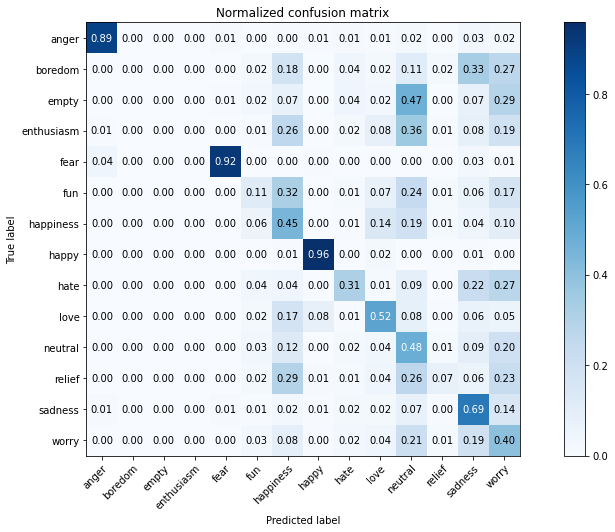

In [13]:
#checking the accuracy of the model
from sklearn.metrics import accuracy_score,f1_score, precision_score, recall_score, confusion_matrix
acc = round(accuracy_score(y_test, test_emotions),4)
pre = round(precision_score(y_test, test_emotions, average='weighted'),4)
rec = round(recall_score(y_test, test_emotions, average='weighted'),4)
f1 = round(f1_score(y_test, test_emotions, average='weighted'),4)

print(" Accuracy", acc)
print(" Precision",pre,"\n","Recall",rec,"\n","F1",f1)

print("\nConfusion Matrix:\n", confusion_matrix(y_test, test_emotions))
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, test_emotions, classes=class_name, normalize=True, title='Normalized confusion matrix')
plt.show()

In [23]:
model_dir = 'distilbert-base-uncased/'
output_dir = './model_save/'+model_dir

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Configuration saved in ./model_save/distilbert-base-uncased/config.json


Saving model to ./model_save/distilbert-base-uncased/


Model weights saved in ./model_save/distilbert-base-uncased/pytorch_model.bin
tokenizer config file saved in ./model_save/distilbert-base-uncased/tokenizer_config.json
Special tokens file saved in ./model_save/distilbert-base-uncased/special_tokens_map.json


('./model_save/distilbert-base-uncased/tokenizer_config.json',
 './model_save/distilbert-base-uncased/special_tokens_map.json',
 './model_save/distilbert-base-uncased/vocab.txt',
 './model_save/distilbert-base-uncased/added_tokens.json',
 './model_save/distilbert-base-uncased/tokenizer.json')

In [53]:
import gc
torch.cuda.empty_cache()
gc.collect()

0